In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pems-dataset/data/PEMS07/PEMS07.csv
/kaggle/input/pems-dataset/data/PEMS07/PEMS07.npz
/kaggle/input/pems-dataset/data/PEMS08/PEMS08.npz
/kaggle/input/pems-dataset/data/PEMS08/PEMS08.csv
/kaggle/input/pems-dataset/data/PEMS03/PEMS03.npz
/kaggle/input/pems-dataset/data/PEMS03/PEMS03.csv
/kaggle/input/pems-dataset/data/PEMS03/PEMS03.txt
/kaggle/input/pems-dataset/data/PEMS04/PEMS04.csv
/kaggle/input/pems-dataset/data/PEMS04/PEMS04.npz


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
data = np.load('/kaggle/input/pems-dataset/data/PEMS04/PEMS04.npz')
X_raw = data['data']  # (T, N, F)
X_raw.shape

(16992, 307, 3)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw.reshape(-1, X_raw.shape[-1])).reshape(X_raw.shape)

In [ ]:
def create_sequences(data, t=12, f=3):
    X, Y = [], []
    # Iterate over the time axis to create rolling windows
    for i in range(len(data) - t - f):
        # Extract input window of shape (t, N, F)
        X.append(data[i : i + t])

        # Extract target window of shape (f, N), focusing only on the first feature (e.g., flow)
        Y.append(data[i + t : i + t + f, :, 0])

    return np.array(X), np.array(Y)

X, y = create_sequences(X_scaled) #(B, t, N, F)

In [ ]:
# Spliting of dataset into 80 -20
train_len = int(0.8 * len(X))
X_train, y_train = X[:train_len], y[:train_len]
X_test, y_test = X[train_len:], y[train_len:]

train_loader = DataLoader(TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float()), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test).float(), torch.tensor(y_test).float()), batch_size=32)

In [20]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.W = nn.Parameter(torch.randn(in_features, out_features) * 0.01)
        self.bn = nn.BatchNorm1d(307)

    def forward(self, H, A):
        """
        H: [N, F] node feature
        A: [N, N] normalized adjacency matrix
        """
        HW = torch.matmul(H, self.W)     # H * W
        AHW = torch.matmul(A, HW)        # A * H * W
        out = F.relu(self.bn(AHW))
        return out


In [ ]:
def build_adjacency_matrix(csv_path, num_nodes):
   
    df = pd.read_csv(csv_path)
    A = np.eye(num_nodes)
    
    for _, row in df.iterrows():
        i, j = int(row['from']), int(row['to'])
        A[i, j] = 1
        A[j, i] = 1  # undirected

    # Compute D^{-1/2}
    D = A.sum(axis=1)
    D_inv_sqrt = np.diag(1 / np.sqrt(D + 1e-8))  #  epsilon to avoid divide-by-zero

    # Normalize: A_norm = D^{-1/2} @ A @ D^{-1/2}
    A_norm = D_inv_sqrt @ A @ D_inv_sqrt

    return torch.tensor(A_norm, dtype=torch.float32)


In [21]:
# # GCN Model for traffic flow prediction
# class GCNModel(nn.Module):
#     def __init__(self, in_features, hidden_features, out_features, num_layers=2):
#         super(GCNModel, self).__init__()
#         self.num_layers = num_layers

#         self.gcn_layers = nn.ModuleList()
#         self.dropout = nn.Dropout(0.2)
        
#         # First layer: input -> hidden
#         self.gcn_layers.append(GCNLayer(in_features, hidden_features))

#         # Middle hidden layers
#         for _ in range(num_layers - 2):
#             self.gcn_layers.append(GCNLayer(hidden_features, hidden_features))
      
#         # Last layer: hidden -> output
#         self.gcn_layers.append(GCNLayer(hidden_features, out_features))

#     def forward(self, X, A):
#         """
#         X: [B, T, N, F]
#         A: [N, N]  normalized adjacency matrix
#         """
#         B, T, N, F = X.shape
#         out_all = []
        
#         for b in range(B):
#             x_last = X[b, -1]  # [N, F]
#             x = x_last
        
#             for layer in self.gcn_layers[:-1]:
#                 x = layer(x, A)
                
        
#             out = self.gcn_layers[-1](x, A)  # [N, out_features]
#             out = self.dropout(out)
#             out = out.permute(1, 0)  # [out_features, N]
#             out_all.append(out)
        
#         return torch.stack(out_all, dim=0)  # [B, out_features, N]

In [22]:
class GCNModel(nn.Module):
    def __init__(self, in_features, hidden_gru, hidden_gcn, out_features, num_layers=2):
        super(GCNModel, self).__init__()

        self.gru = nn.GRU(in_features, hidden_gru, batch_first=True)
        
        self.gcn_layers = nn.ModuleList()
        
        self.dropout = nn.Dropout(0.3)

        # First GCN layer
        self.gcn_layers.append(GCNLayer(hidden_gru, hidden_gcn))

        # Optional additional layers
        for _ in range(num_layers - 2):
            self.gcn_layers.append(GCNLayer(hidden_gcn, hidden_gcn))

        # Output layer
        self.output_layer = nn.Linear(hidden_gcn, out_features)

    def forward(self, X, A):
        """
        X: [B, T, N, F]
        A: [N, N]
        Returns: [B, out_features, N]
        """
        B, T, N, F = X.shape
        X = X.permute(0, 2, 1, 3).reshape(B*N, T, F)  # [B*N, T, F]
        _, h_n = self.gru(X)                         # [1, B*N, hidden_gru]
        h_n = h_n.squeeze(0).reshape(B, N, -1)       # [B, N, hidden_gru]

        out = h_n
        for gcn in self.gcn_layers:
            out = gcn(out, A)

        out = self.dropout(out)                      
        out = self.output_layer(out) # [B, N, out_features]
        out = out.permute(0, 2, 1)  # [B, out_features, N]
        return out


In [27]:

adj = build_adjacency_matrix('/kaggle/input/pems-dataset/data/PEMS04/PEMS04.csv', X.shape[2])

In [28]:

# Training setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'


model = GCNModel(X.shape[-1], hidden_gru=64, hidden_gcn=64, out_features=y.shape[1]).to(device)
# model = GCNModel(X.shape[-1], hidden_features=64, out_features=y.shape[1]).to(device)

opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


flow_mean, flow_std = scaler.mean_[0], scaler.scale_[0]

In [29]:

def evaluate(model, loader):
    model.eval()
    preds = []
    trues = []

    with torch.no_grad():
        for Xb, yb in loader:
            Xb = Xb.to(device).float()
            yb = yb.to(device).float()

            pred = model(Xb, adj.to(device))  # [B, h, N]

            # Move to CPU and convert to numpy
            pred_np = pred.detach().cpu().numpy()
            true_np = yb.detach().cpu().numpy()

            # Inverse standardization: pred * std + mean
            pred_np = pred_np * flow_std + flow_mean
            true_np = true_np * flow_std + flow_mean

            preds.append(pred_np.reshape(-1))  # flatten to 1D
            trues.append(true_np.reshape(-1))

    preds = np.concatenate(preds)
    trues = np.concatenate(trues)

    return (
        mean_absolute_error(trues, preds),
        np.sqrt(mean_squared_error(trues, preds)),
        r2_score(trues, preds)
    )

In [30]:
print('Started Trainning............')
num_epoch = 25
for epoch in range(1, num_epoch+1):
    
    model.train()
    total_loss = 0
    
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        
        opt.zero_grad()
        pred = model(Xb, adj.to(device))
        loss = loss_fn(pred, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    val_mae, val_rmse, val_r2 = evaluate(model, test_loader)
    
    print(f"Epoch {epoch}/{num_epoch}| Train Loss: {total_loss/len(train_loader):.4f}"
          f" | Val MAE: {val_mae:.3f}, RMSE: {val_rmse:.3f}, R²: {val_r2:.3f}")

Started Trainning............
Epoch 1/25| Train Loss: 0.1428 | Val MAE: 29.502, RMSE: 42.934, R²: 0.926
Epoch 2/25| Train Loss: 0.0916 | Val MAE: 28.344, RMSE: 41.567, R²: 0.931
Epoch 3/25| Train Loss: 0.0856 | Val MAE: 27.446, RMSE: 40.665, R²: 0.934
Epoch 4/25| Train Loss: 0.0827 | Val MAE: 27.152, RMSE: 40.463, R²: 0.935
Epoch 5/25| Train Loss: 0.0812 | Val MAE: 27.631, RMSE: 40.802, R²: 0.933
Epoch 6/25| Train Loss: 0.0805 | Val MAE: 27.037, RMSE: 40.178, R²: 0.935
Epoch 7/25| Train Loss: 0.0800 | Val MAE: 27.303, RMSE: 40.574, R²: 0.934
Epoch 8/25| Train Loss: 0.0800 | Val MAE: 26.845, RMSE: 39.902, R²: 0.936
Epoch 9/25| Train Loss: 0.0790 | Val MAE: 27.243, RMSE: 40.518, R²: 0.934
Epoch 10/25| Train Loss: 0.0792 | Val MAE: 27.562, RMSE: 40.253, R²: 0.935
Epoch 11/25| Train Loss: 0.0786 | Val MAE: 26.544, RMSE: 39.711, R²: 0.937
Epoch 12/25| Train Loss: 0.0781 | Val MAE: 26.802, RMSE: 39.897, R²: 0.936
Epoch 13/25| Train Loss: 0.0778 | Val MAE: 26.963, RMSE: 39.927, R²: 0.936
Epoc

In [31]:
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        pred = model(Xb, adj.to(device)).cpu().numpy()
        true = yb.cpu().numpy()
        preds.append(pred)
        trues.append(true)
preds = np.concatenate(preds)
trues = np.concatenate(trues)

preds = preds * scaler.scale_[0] + scaler.mean_[0]
trues = trues * scaler.scale_[0] + scaler.mean_[0]

In [42]:
a = preds.reshape(-1)
a.shape
# preds.shape

(3127716,)

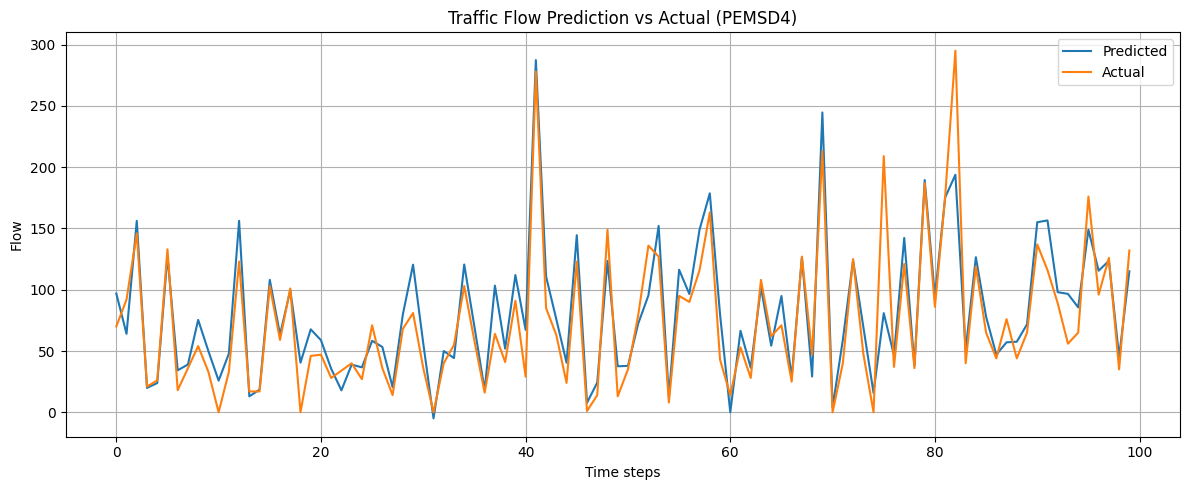

In [47]:

plt.figure(figsize=(12, 5))
plt.plot(preds.reshape(-1)[:100], label='Predicted')
plt.plot(trues.reshape(-1)[:100], label='Actual')
plt.legend()
plt.title("Traffic Flow Prediction vs Actual (PEMSD4)")
plt.xlabel("Time steps")
plt.ylabel("Flow")
plt.grid(True)
plt.tight_layout()
plt.show()